<a href="https://colab.research.google.com/github/fcoelhomrc/MachineLearning/blob/main/TAAPC_Assignments%5Cassignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchtext
from tqdm import tqdm
from collections import Counter, OrderedDict

In [2]:
url_train = "https://raw.githubusercontent.com/fcoelhomrc/MachineLearning/main/TAAPC_Assignments/imdb_train.csv"
url_test = "https://raw.githubusercontent.com/fcoelhomrc/MachineLearning/main/TAAPC_Assignments/imdb_test.csv"

imdb_train = pd.read_csv(url_train)
imdb_test = pd.read_csv(url_test, names=imdb_train.columns)

In [3]:
imdb_test.head()

,review,sentiment
0,"I saw the film many times, and every time I am...",negative
1,I loved KOLCHAK: THE NIGHT STALKER since I saw...,positive
2,This feels as if it is a Czech version of Pear...,positive
3,"When, oh, when will someone like Anchor Bay or...",positive
4,"""Just before dawn "" is one of the best slasher...",positive


In [4]:
print(imdb_train.shape, imdb_test.shape)
print(imdb_train.columns, imdb_test.columns)

(45000, 2) (5000, 2)
Index(['review', 'sentiment'], dtype='object') Index(['review', 'sentiment'], dtype='object')


The outline of this project is
1. Pre-process the data, defining a vocabulary and converting it to a sparse representation
2. Pre-train an embedding layer to transform into a dense representation
3. Use each embedded sequence as input to a GRU layer, and then use a Linear layer with sigmoid activation to map output into a single binary prediction (many-to-one model)

We will have to deal with different length sequences while mini-batching. [This post](https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e) and [this repository](https://gist.github.com/HarshTrivedi/f4e7293e941b17d19058f6fb90ab0fec) explain PyTorch implementations to do that.

# Stage 1: estabilish the vocabulary

Generate the vocabulary

In [5]:
tokenizer = torchtext.data.get_tokenizer("basic_english")

def get_vocab_freq(data):
    counter = Counter()
    for sentence in data["review"]:
        tokenized_sentence = tokenizer(sentence)
        counter.update(tokenized_sentence)
    return OrderedDict(counter)

imdb_data = pd.concat([imdb_train, imdb_test], axis=0, ignore_index=True) # fetch vocab considering complete data

vocab_freq = get_vocab_freq(imdb_data)

pad_token = "<pad>" # Token representing padding
vocab = torchtext.vocab.vocab(vocab_freq, min_freq=50,
                              specials=[pad_token], special_first=True)
vocab.set_default_index(-1) # Unknown words will return -1

In [6]:
print(len(vocab), vocab[pad_token])

11264 0


In [7]:
sequence_len = [len(tokenizer(seq)) for seq in imdb_data["review"]]
mean_length = np.array(sequence_len).mean()
print(f"Mean sequence length: {mean_length}")
PADDED_LENGTH = max(sequence_len)
PADDED_LENGTH

Mean sequence length: 267.66206


2752

# Stage 2: pre-train an Embedding

Following what we have done in class, we will implement a Word2Vec model to pre-train our embedding layer with a SkipGram scheme.

We have way too much data for SkipGram model:
$$
\text{total_examples} \approx \text{window_size} \times 50\text{k} \times \text{avg_length} \sim 50\times 10^6
$$
Therefore, we sample about 10% of the complete dataset in order to train our embedding.

In [20]:
class SkipGramDataset(torch.utils.data.Dataset):
    def __init__(self, data, vocab_with_special, window_width, pad_token):
        self.inputs = []
        self.contexts = []
        vocab = {key: value-1 for key, value in vocab_with_special.get_stoi().items() \
                 if key != pad_token}
        vocab_inv = {key: value for value, key in vocab.items()}
        self.vocabs = [vocab, vocab_inv]
        # Keep track of number of valid examples (we skip OOV words)
        num_examples = 0
        # Pick input, context pairs as in regular SkipGram
        print("Generating skip-grams...")
        for sequence in data["review"]:
            tokens = tokenizer(sequence)
            length = len(tokens)
            for i, tk in enumerate(tokens):
                if tk not in vocab or tk == "<unk>" or tk == "<pad>":
                    continue
                # Treat beginning and end of token sequence as special cases
                left_idx, right_idx = i - window_width, i + window_width + 1
                left_idx = 0 if i < window_width else left_idx
                right_idx = length if i > length - (window_width + 1) else right_idx
                for j in range(left_idx, right_idx):
                    if j == i:
                        continue
                    next_tk = tokens[j]
                    if next_tk not in vocab or next_tk == "<unk>" or next_tk == "<pad>":
                        continue
                    else:
                        self.inputs.append(vocab[tk])
                        self.contexts.append(vocab[next_tk])
                        num_examples += 1
        print("Finished generating skip-grams.")
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        return self.inputs[index], self.contexts[index]
    
    def get_vocabs(self):
        return self.vocabs

In [21]:
WINDOW_WIDTH = 4
sample_size = 0.1
imdb_sampled = imdb_data.sample(frac=sample_size, random_state=42)

w2v_dataset = SkipGramDataset(imdb_sampled, vocab, WINDOW_WIDTH, pad_token)
print(f"Dataset has {len(w2v_dataset)} examples.")

Generating skip-grams...
Finished generating skip-grams.
Dataset has 9807150 examples.


In [22]:
for i in range(0, 50):
    x, y = w2v_dataset[i]
    vocab_inv = w2v_dataset.get_vocabs()[1]
    x_word = vocab_inv[x]
    y_word = vocab_inv[y]
    print(x_word, y_word)

half of
half the
half movie
half is
of half
of the
of movie
of is
of is
the half
the of
the movie
the is
the is
the flashing
movie half
movie of
movie the
movie is
movie is
movie flashing
movie lights
is half
is of
is the
is movie
is is
is flashing
is lights
is and
is of
is the
is movie
is is
is flashing
is lights
is and
is shaky
flashing the
flashing movie
flashing is
flashing is
flashing lights
flashing and
flashing shaky
flashing camera
lights movie
lights is
lights is
lights flashing


In [8]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, embed_max_norm=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim,
                                      max_norm=embed_max_norm)
        self.linear = nn.Linear(in_features=embed_dim,
                                out_features=vocab_size)       
    
    def forward(self, x):
        embedded = self.embedding(x)
        logits = self.linear(embedded)
        return logits

In [24]:
def w2v_fit(model, train_loader, optimizer, **kwargs):
    
    num_epochs = kwargs.get('num_epochs', 100)
    loss_fn = kwargs.get('loss_fn', nn.functional.cross_entropy)
    device = kwargs.get('device', torch.device('cpu'))
    
    model.train()
    train_loss_hist, train_acc_hist = [], []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}')
        pbar = tqdm(train_loader, total=len(train_loader))
        train_loss, train_acc = 0, 0
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                preds = logits.argmax(dim=1)
            acc = (preds == y).float().sum() / ((y != -100).float().sum() + 1e-6)
            train_loss += loss.item()
            train_acc += acc.item()
            pbar.set_description(f'loss = {loss:.3f} | acc = {acc:.3f}')

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f'train loss = {train_loss:.3f} | train acc = {train_acc:.3f}')
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)
        
    return train_loss_hist, train_acc_hist

In [9]:
EMBEDDING_DIM = 300
EMBEDDING_MAX_NORM = 1
BATCH_SIZE = 128
NUM_EPOCHS = 5
LEARNING_RATE = 1e-4

In [26]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("DEVICE:", DEVICE)

w2v_model = SkipGramModel(vocab_size=len(vocab)-1, embed_dim=EMBEDDING_DIM,
                          embed_max_norm=EMBEDDING_MAX_NORM).to(DEVICE)

optimizer = torch.optim.Adam(w2v_model.parameters(), lr=LEARNING_RATE)
w2v_dataloader = torch.utils.data.DataLoader(w2v_dataset, batch_size=BATCH_SIZE, shuffle=True)

DEVICE: cuda


In [27]:
train_loss, train_acc = w2v_fit(w2v_model, w2v_dataloader,
                                optimizer, num_epochs=NUM_EPOCHS, device=DEVICE)

Epoch 0


loss = 5.591 | acc = 0.043: 100%|████████████████████████████████████████████████| 76619/76619 [16:52<00:00, 75.67it/s]


train loss = 6.391 | train acc = 0.061
Epoch 1


loss = 5.636 | acc = 0.043: 100%|████████████████████████████████████████████████| 76619/76619 [16:34<00:00, 77.03it/s]


train loss = 6.224 | train acc = 0.066
Epoch 2


loss = 6.293 | acc = 0.109: 100%|████████████████████████████████████████████████| 76619/76619 [16:27<00:00, 77.62it/s]


train loss = 6.192 | train acc = 0.066
Epoch 3


loss = 6.895 | acc = 0.065: 100%|████████████████████████████████████████████████| 76619/76619 [16:23<00:00, 77.91it/s]


train loss = 6.171 | train acc = 0.067
Epoch 4


loss = 6.225 | acc = 0.087: 100%|████████████████████████████████████████████████| 76619/76619 [16:11<00:00, 78.85it/s]

train loss = 6.155 | train acc = 0.067


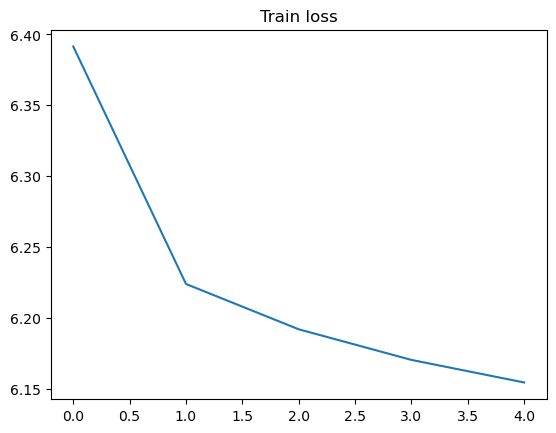

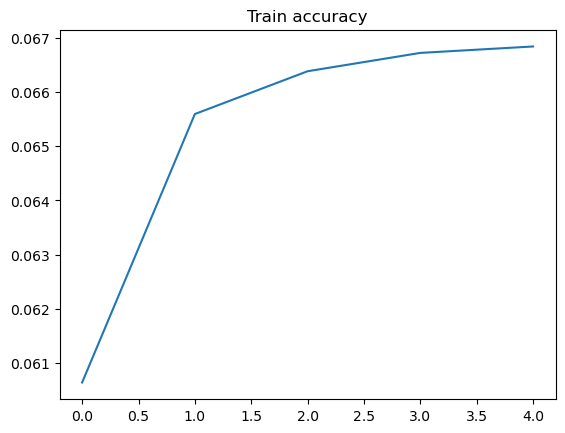

In [28]:
plt.title('Train loss')
plt.plot(range(len(train_loss)), train_loss)
plt.show()
plt.title('Train accuracy')
plt.plot(range(len(train_acc)), train_acc)
plt.show()

In [10]:
# torch.save(w2v_model.state_dict(), f"imdb_word2vec_E{EMBEDDING_DIM}_EMN{EMBEDDING_MAX_NORM}.pt")
# Model to load
MODEL_TO_LOAD = f"imdb_word2vec_E{EMBEDDING_DIM}_EMN{EMBEDDING_MAX_NORM}.pt"
MODEL_TO_LOAD

'imdb_word2vec_E300_EMN1.pt'

# Stage 3: tackle Sentiment Analysis task

Create a custom `Dataset` and `DataLoader` to automatically handle mini-batching.

The `IMDBDataset` object should store each review in a sparse representation and map the sentiment into binary categories: `{0: "negative", 1: "positive"}`.

Moreover, it will pad each review with `<pad>` tokens. This will be managed later by the `pack_padded_sequence` and `pad_packed_sequence` functions.

In [11]:
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, data, vocab, tokenizer, max_len, pad_token):
        self.inputs = []
        self.targets = []
        self.lengths = []

        print(f"Loading data...")
        print(f"Padding inputs...")
        for sentence in data["review"]:
            # Tokenize review
            tokenized_sentence = tokenizer(sentence)
            # Skip unknown tokens
            padded_sentence = [vocab[tk] for tk in tokenized_sentence if vocab[tk] >= 0] 
            # Save length before padding
            self.lengths.append(len(padded_sentence)) 
            # Apply padding
            padding_size = max_len - len(padded_sentence)
            padded_sentence.extend([vocab[pad_token]]*padding_size)
            # Append result
            self.inputs.append(padded_sentence)
        print("Finished padding inputs. Processing labels...")
        for label in data["sentiment"]:
            self.targets.append(0 if label == "negative" else 1)
        print("Done.")

    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        # Must also return original length before padding
        return {"inputs": self.inputs[idx],
                "targets": self.targets[idx],
                "lengths": self.lengths[idx]}
        # return self.inputs[idx], self.targets[idx], self.lengths[idx]

Instantiate the `DataLoaders`, splitting the train data into train/validation sets. For the train/validation splitting, refer [to this post.](https://clay-atlas.com/us/blog/2021/08/25/pytorch-en-random-split-data-set/)

In [12]:
train_dataset = IMDBDataset(imdb_train, vocab, tokenizer, PADDED_LENGTH, pad_token)
test_dataset = IMDBDataset(imdb_test, vocab, tokenizer, PADDED_LENGTH, pad_token)

train_split = int(0.9 * len(train_dataset))
validation_split = len(train_dataset) - train_split
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset,
                                                                  [train_split, validation_split])

BATCH_SIZE = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

Loading data...
Padding inputs...
Finished padding inputs. Processing labels...
Done.
Loading data...
Padding inputs...
Finished padding inputs. Processing labels...
Done.


Now we need to define our model:

[![](https://mermaid.ink/img/pako:eNplkU9PwzAMxb9K5BNIm9CuparEOokLpyFOZKqyxrQWSRry5zBt--54bWFM-BTF7_f84hyhHTRCAV1Qvhcv20fpBNfTuwRyPicJO7FcVicJ0asQUcJJrLmJdo9ak-skiHIfKlFGq4ypxNhoNFlRPkxXu8lyPftodJNNzTbP27db3GXbGHXAEH_5Cf9fN1xPmo2bmFTCKwnz7HqeTQmDMOjuIn5ldC3ej0H-iES94liGHKpwxVc_O6DODqQv0IZlPqCmNtHgRikswGKwijQv9HhBJaQeLb-24KNW4VOCdGfWqZyG14NroUgh4wKy1xx8Q4r_wULxoUzE8zegXYC2)](https://mermaid.live/edit#pako:eNplkU9PwzAMxb9K5BNIm9CuparEOokLpyFOZKqyxrQWSRry5zBt--54bWFM-BTF7_f84hyhHTRCAV1Qvhcv20fpBNfTuwRyPicJO7FcVicJ0asQUcJJrLmJdo9ak-skiHIfKlFGq4ypxNhoNFlRPkxXu8lyPftodJNNzTbP27db3GXbGHXAEH_5Cf9fN1xPmo2bmFTCKwnz7HqeTQmDMOjuIn5ldC3ej0H-iES94liGHKpwxVc_O6DODqQv0IZlPqCmNtHgRikswGKwijQv9HhBJaQeLb-24KNW4VOCdGfWqZyG14NroUgh4wKy1xx8Q4r_wULxoUzE8zegXYC2)

Some comments:
- Unlike the Word2Vec model implemented in class, we don't need to use a `nn.Linear` layer to map from embedding space to vocabulary space. 

- We should load weights the Word2Vec we trained above into the sentiment analysis model Embedding layer. Note this fixes its embedding size. 

- After initializing the pre-trained weights, we can freeze them to avoid getting messed up by the first epochs. A common strategy is to later unfreeze these layers.

- The model is based around a `nn.GRU` layer, which allow us to chain many GRU units for processing each sequence. In the end, we are only interest in the output of the final GRU layer. 

- Note that we will use `torch.nn.utils.rnn.pack_padded_sequence` to feed input to GRU as to avoid flooding it with padding tokens. The output will still be in packed form, but it is not necessary to reverse the operation since our prediction is based upon the hidden state.

- We don't need to include `nn.Sigmoid` explicitly, since our loss function (`nn.BCEWithLogitsLoss`) will implement it for us (with more numerical stability, [c.f. documentation](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)).

In [90]:
class GRUPredictor(nn.Module):

    def __init__(self, vocab_size,
                 hidden_size, num_layers, is_bidirectional=True, dropout=0.5,
                 embed_dim=300, embed_max_norm=None, pretrained=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim,
                                      padding_idx=0,
                                      max_norm=embed_max_norm)
        self.D = 2 if is_bidirectional else 1
        if pretrained is not None:
            self.set_pretrained(pretrained)
        
        self.gru = nn.GRU(input_size=embed_dim, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, bidirectional=is_bidirectional)
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(self.D*hidden_size, 1)
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        
    def forward(self, inputs, unpadded_lengths):
        # sort inputs by descending unpadded length
        unpadded_lengths, sort_idx = unpadded_lengths.sort(descending=True)
        unpadded_lengths = unpadded_lengths.cpu().numpy()
        inputs = inputs[sort_idx]
        # map <unk> to <pad>, unknown words won't contribute to gradient
        inputs = torch.where(inputs < 0, 0, inputs)
        # embed inputs
        embedded_inputs = self.embedding(inputs)
        BS, T, _ = embedded_inputs.shape # X -> batch, steps, embed_dim 
        # initialize hidden state
        self.hidden_state = torch.zeros((self.D*self.num_layers, BS, self.hidden_size),
                                        device=inputs.device)
        # pack_padded_sequence so that padded items in the sequence won't be shown to the GRU
        X = torch.nn.utils.rnn.pack_padded_sequence(embedded_inputs, unpadded_lengths,
                                                    batch_first=True)
        # rnn pass
        X, self.hidden_state = self.gru(X, self.hidden_state)
        # prediction using forward/backward final outputs
        output = torch.cat([self.hidden_state[-2,:,:], self.hidden_state[-1,:,:]], dim=1)
        output = self.dropout(output) # dropout between GRU and Linear layer
        output = self.linear(output)
        return output
    
    def set_pretrained(self, path):
        state_dict = torch.load(path)
        pretrained_weights = state_dict["embedding.weight"]
        with torch.no_grad():
            self.embedding.weight[1:] = pretrained_weights # Don't touch padding embedding
        self.embedding.weight.requires_grad = False # Freeze weights

Now we need to write the training loop, etc.
Most of the code below is based on what was supplied to us in the earlier modules.

Comment about `nn.functional.binary_cross_entropy_with_logits`: the targets $y$ need to be a float tensor, since the loss function can work with soft labels representing probability of the positive class.
[Source](https://discuss.pytorch.org/t/multi-label-binary-classification-result-type-float-cant-be-cast-to-the-desired-output-type-long/117915/3)

In [100]:
HIDDEN_SIZE = 256
NUM_LAYERS = 2
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100
BIDIRECTIONAL = True
DROPUT_RATE = 0.5

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
# DEVICE = "cpu"
    
    
print("DEVICE:", DEVICE)
print("EMBEDDING DIM:", EMBEDDING_DIM)

model = GRUPredictor(len(vocab), HIDDEN_SIZE, NUM_LAYERS, is_bidirectional=BIDIRECTIONAL, dropout=DROPUT_RATE,
                     embed_dim=EMBEDDING_DIM, embed_max_norm=True, pretrained=MODEL_TO_LOAD).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Check that the weights were successfully loaded
w2v_model = SkipGramModel(len(vocab)-1, EMBEDDING_DIM).to(DEVICE)
w2v_model.load_state_dict(torch.load(MODEL_TO_LOAD))
print(model.state_dict()["embedding.weight"][0])
torch.equal(model.state_dict()["embedding.weight"][1:], w2v_model.state_dict()["embedding.weight"])

DEVICE: cuda
EMBEDDING DIM: 300
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 

True

So what we have here is that the Embedding layer will always map the padding to the zero vector, and the remaining of the vocabulary will be mapped the same as the pre-trained Embedding.

In [101]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {pytorch_trainable_params} trainable parameters" \
      + f"and {pytorch_total_params - pytorch_trainable_params} non-trainable parameters")
print(f"Total: {pytorch_total_params}")

The model has 2040321 trainable parametersand 3379200 non-trainable parameters
Total: 5419521


In [102]:
print(model)

GRUPredictor(
  (embedding): Embedding(11264, 300, padding_idx=0, max_norm=True)
  (gru): GRU(300, 256, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=512, out_features=1, bias=True)
)


In [103]:
def evaluate(model, data_loader, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.functional.binary_cross_entropy_with_logits)
    device = kwargs.get("device", torch.device("cpu"))
    
    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    avg_loss, avg_acc = 0., 0.
    for i, batch in pbar:

        batch["inputs"] = (torch.stack(batch["inputs"]).T).to(device)
        batch["targets"] = batch["targets"].float().to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad(): # no need to compute gradients
            preds = model(batch["inputs"], batch["lengths"])
            probas = torch.sigmoid(preds)
            pred_cats = probas.argmax(dim=1)
            acc = (pred_cats == batch["targets"]).float().sum()
            acc /= ((batch["targets"] != -100).float().sum() + 1e-6)
        loss = loss_fn(preds.squeeze(), batch["targets"])
        avg_loss += loss.item()
        avg_acc += acc.item()
        pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
    avg_loss /= len(data_loader)
    avg_acc /= len(data_loader)
    return avg_loss, avg_acc

def fit(model, train_loader, val_loader, optimizer, **kwargs):
    num_epochs = kwargs.get("num_epochs", 100)
    loss_fn = kwargs.get("loss_fn", nn.functional.binary_cross_entropy_with_logits)
    device = kwargs.get("device", torch.device("cpu"))
    
    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        model.train() # set model to training mode
        train_loss, train_acc = 0., 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, batch in pbar:
            
            batch["inputs"] = (torch.stack(batch["inputs"]).T).to(device)
            batch["targets"] = batch["targets"].float().to(device)
    
            model.zero_grad() # initialize gradients to zero
            preds = model(batch["inputs"], batch["lengths"]) # forward pass
            loss = loss_fn(preds.squeeze(), batch["targets"]) # loss computation
            loss.backward() # computing gradients (backward pass)
            optimizer.step() # updating the parameters of the model
            # accuracy computation
            with torch.no_grad():
                probas = torch.sigmoid(preds)
                pred_cats = probas.argmax(dim=1)
                acc = (pred_cats == batch["targets"]).float().sum()
                acc /= ((batch["targets"] != -100).float().sum() + 1e-6)
            # pop computational graph
            train_loss += loss.item()
            train_acc += acc.item()
            pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f"Train loss: {train_loss:.3f} | train acc = {train_acc:.3f}")
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc) 
        
        val_loss, val_acc = evaluate(model, val_loader, loss_fn=loss_fn, device=device)
        print(f"Validation loss: {val_loss:.3f} | val acc = {val_acc:.3f}")
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)
        
    return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist


In [104]:
train_loss, val_loss, train_acc, val_acc = fit(model, train_dataloader, validation_dataloader,
                                               optimizer, num_epochs=NUM_EPOCHS, device=DEVICE)


Epoch 1/100


loss = 0.690 | acc = 0.500: 100%|████████████████████████████████████████████████████| 317/317 [02:37<00:00,  2.01it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.684 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.54it/s]


Validation loss: 0.695 | val acc = 0.496

Epoch 2/100


loss = 0.690 | acc = 0.538: 100%|████████████████████████████████████████████████████| 317/317 [02:36<00:00,  2.03it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.688 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.53it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 3/100


loss = 0.685 | acc = 0.596: 100%|████████████████████████████████████████████████████| 317/317 [02:35<00:00,  2.04it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.694 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.18it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 4/100


loss = 0.696 | acc = 0.365: 100%|████████████████████████████████████████████████████| 317/317 [02:35<00:00,  2.04it/s]


Train loss: 0.694 | train acc = 0.501


loss = 0.690 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.56it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 5/100


loss = 0.691 | acc = 0.500: 100%|████████████████████████████████████████████████████| 317/317 [02:35<00:00,  2.04it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.688 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.55it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 6/100


loss = 0.702 | acc = 0.615: 100%|████████████████████████████████████████████████████| 317/317 [02:35<00:00,  2.04it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.697 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.13it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 7/100


loss = 0.692 | acc = 0.519: 100%|████████████████████████████████████████████████████| 317/317 [02:35<00:00,  2.04it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.694 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.55it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 8/100


loss = 0.698 | acc = 0.442: 100%|████████████████████████████████████████████████████| 317/317 [02:35<00:00,  2.04it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.689 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.54it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 9/100


loss = 0.694 | acc = 0.442: 100%|████████████████████████████████████████████████████| 317/317 [02:35<00:00,  2.04it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.684 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.55it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 10/100


loss = 0.691 | acc = 0.500: 100%|████████████████████████████████████████████████████| 317/317 [02:36<00:00,  2.03it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.686 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:07<00:00,  4.54it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 11/100


loss = 0.692 | acc = 0.500: 100%|████████████████████████████████████████████████████| 317/317 [02:36<00:00,  2.02it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.694 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.43it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 12/100


loss = 0.688 | acc = 0.442: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.698 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.41it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 13/100


loss = 0.700 | acc = 0.538: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.690 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:09<00:00,  3.87it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 14/100


loss = 0.688 | acc = 0.481: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.96it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.691 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.42it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 15/100


loss = 0.699 | acc = 0.558: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.697 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.38it/s]


Validation loss: 0.695 | val acc = 0.496

Epoch 16/100


loss = 0.692 | acc = 0.442: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.685 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.41it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 17/100


loss = 0.688 | acc = 0.538: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.697 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.42it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 18/100


loss = 0.698 | acc = 0.577: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.690 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.38it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 19/100


loss = 0.693 | acc = 0.462: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.694 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.42it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 20/100


loss = 0.692 | acc = 0.500: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.691 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.42it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 21/100


loss = 0.702 | acc = 0.442: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.693 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.42it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 22/100


loss = 0.693 | acc = 0.442: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.689 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.43it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 23/100


loss = 0.694 | acc = 0.500: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.691 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.07it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 24/100


loss = 0.695 | acc = 0.519: 100%|████████████████████████████████████████████████████| 317/317 [02:42<00:00,  1.95it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.691 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.41it/s]


Validation loss: 0.699 | val acc = 0.496

Epoch 25/100


loss = 0.691 | acc = 0.519: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.690 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.37it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 26/100


loss = 0.693 | acc = 0.462: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.693 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.41it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 27/100


loss = 0.689 | acc = 0.462: 100%|████████████████████████████████████████████████████| 317/317 [02:42<00:00,  1.96it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.691 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.39it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 28/100


loss = 0.695 | acc = 0.462: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.700 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.42it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 29/100


loss = 0.700 | acc = 0.365: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.501


loss = 0.696 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.31it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 30/100


loss = 0.694 | acc = 0.346: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.96it/s]


Train loss: 0.694 | train acc = 0.501


loss = 0.690 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.41it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 31/100


loss = 0.693 | acc = 0.519: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.695 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.40it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 32/100


loss = 0.695 | acc = 0.481: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.692 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.34it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 33/100


loss = 0.690 | acc = 0.558: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.693 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.06it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 34/100


loss = 0.693 | acc = 0.462: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.691 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.41it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 35/100


loss = 0.685 | acc = 0.558: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.96it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.702 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.36it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 36/100


loss = 0.697 | acc = 0.558: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.96it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.700 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.43it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 37/100


loss = 0.692 | acc = 0.538: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.694 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.42it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 38/100


loss = 0.689 | acc = 0.442: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.696 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.36it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 39/100


loss = 0.701 | acc = 0.596: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.696 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.42it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 40/100


loss = 0.695 | acc = 0.519: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.700 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.08it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 41/100


loss = 0.695 | acc = 0.462: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.693 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.40it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 42/100


loss = 0.695 | acc = 0.519: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.689 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.43it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 43/100


loss = 0.691 | acc = 0.596: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.694 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.37it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 44/100


loss = 0.691 | acc = 0.596: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.96it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.691 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.42it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 45/100


loss = 0.700 | acc = 0.404: 100%|████████████████████████████████████████████████████| 317/317 [02:39<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.501


loss = 0.693 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.32it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 46/100


loss = 0.697 | acc = 0.500: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.690 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.38it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 47/100


loss = 0.693 | acc = 0.404: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.501


loss = 0.689 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.44it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 48/100


loss = 0.700 | acc = 0.519: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.700 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.45it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 49/100


loss = 0.701 | acc = 0.673: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.693 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.38it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 50/100


loss = 0.703 | acc = 0.558: 100%|████████████████████████████████████████████████████| 317/317 [02:39<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.688 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.04it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 51/100


loss = 0.702 | acc = 0.462: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.691 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.42it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 52/100


loss = 0.697 | acc = 0.538: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.685 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.44it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 53/100


loss = 0.694 | acc = 0.577: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.700 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.44it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 54/100


loss = 0.695 | acc = 0.615: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.696 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.40it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 55/100


loss = 0.692 | acc = 0.519: 100%|████████████████████████████████████████████████████| 317/317 [02:39<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.696 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.30it/s]


Validation loss: 0.695 | val acc = 0.496

Epoch 56/100


loss = 0.692 | acc = 0.500: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.692 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.43it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 57/100


loss = 0.696 | acc = 0.500: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.96it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.699 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.42it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 58/100


loss = 0.690 | acc = 0.519: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.694 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.44it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 59/100


loss = 0.694 | acc = 0.462: 100%|████████████████████████████████████████████████████| 317/317 [02:39<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.694 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.36it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 60/100


loss = 0.694 | acc = 0.404: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.501


loss = 0.697 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.09it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 61/100


loss = 0.692 | acc = 0.481: 100%|████████████████████████████████████████████████████| 317/317 [02:39<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.692 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.44it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 62/100


loss = 0.688 | acc = 0.558: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.693 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.40it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 63/100


loss = 0.691 | acc = 0.404: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.501


loss = 0.696 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.45it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 64/100


loss = 0.700 | acc = 0.442: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.692 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.43it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 65/100


loss = 0.690 | acc = 0.596: 100%|████████████████████████████████████████████████████| 317/317 [02:39<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.691 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.41it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 66/100


loss = 0.693 | acc = 0.462: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.692 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.40it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 67/100


loss = 0.685 | acc = 0.635: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.693 | train acc = 0.502


loss = 0.695 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.38it/s]


Validation loss: 0.695 | val acc = 0.496

Epoch 68/100


loss = 0.691 | acc = 0.500: 100%|████████████████████████████████████████████████████| 317/317 [02:39<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.693 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.42it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 69/100


loss = 0.692 | acc = 0.346: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.501


loss = 0.690 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.44it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 70/100


loss = 0.697 | acc = 0.423: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.693 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.06it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 71/100


loss = 0.688 | acc = 0.615: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.693 | train acc = 0.502


loss = 0.692 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.44it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 72/100


loss = 0.696 | acc = 0.538: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.693 | train acc = 0.502


loss = 0.695 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.35it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 73/100


loss = 0.691 | acc = 0.538: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.698 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.42it/s]


Validation loss: 0.696 | val acc = 0.496

Epoch 74/100


loss = 0.693 | acc = 0.519: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.692 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.44it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 75/100


loss = 0.692 | acc = 0.519: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.698 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.34it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 76/100


loss = 0.696 | acc = 0.481: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.695 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.42it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 77/100


loss = 0.693 | acc = 0.577: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.691 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:09<00:00,  4.00it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 78/100


loss = 0.690 | acc = 0.462: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.695 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.40it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 79/100


loss = 0.689 | acc = 0.404: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.501


loss = 0.698 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.44it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 80/100


loss = 0.692 | acc = 0.538: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.692 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.36it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 81/100


loss = 0.697 | acc = 0.442: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.693 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.43it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 82/100


loss = 0.705 | acc = 0.712: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.691 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.36it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 83/100


loss = 0.689 | acc = 0.635: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.689 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.37it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 84/100


loss = 0.692 | acc = 0.404: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.694 | train acc = 0.501


loss = 0.696 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.42it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 85/100


loss = 0.694 | acc = 0.558: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.693 | train acc = 0.502


loss = 0.691 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.43it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 86/100


loss = 0.694 | acc = 0.481: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.694 | train acc = 0.502


loss = 0.694 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.42it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 87/100


loss = 0.701 | acc = 0.327: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.695 | train acc = 0.501


loss = 0.752 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.06it/s]


Validation loss: 0.753 | val acc = 0.496

Epoch 88/100


loss = 0.711 | acc = 0.519: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.708 | train acc = 0.502


loss = 0.697 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.36it/s]


Validation loss: 0.697 | val acc = 0.496

Epoch 89/100


loss = 0.705 | acc = 0.500: 100%|████████████████████████████████████████████████████| 317/317 [02:39<00:00,  1.98it/s]


Train loss: 0.702 | train acc = 0.502


loss = 0.691 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.41it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 90/100


loss = 0.684 | acc = 0.558: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.699 | train acc = 0.502


loss = 0.695 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.42it/s]


Validation loss: 0.696 | val acc = 0.496

Epoch 91/100


loss = 0.680 | acc = 0.365: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.698 | train acc = 0.501


loss = 0.696 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.34it/s]


Validation loss: 0.696 | val acc = 0.496

Epoch 92/100


loss = 0.699 | acc = 0.538: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.698 | train acc = 0.502


loss = 0.694 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.44it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 93/100


loss = 0.674 | acc = 0.423: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.697 | train acc = 0.502


loss = 0.696 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.41it/s]


Validation loss: 0.696 | val acc = 0.496

Epoch 94/100


loss = 0.697 | acc = 0.462: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.697 | train acc = 0.502


loss = 0.694 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.02it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 95/100


loss = 0.700 | acc = 0.462: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.696 | train acc = 0.502


loss = 0.702 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.44it/s]


Validation loss: 0.698 | val acc = 0.496

Epoch 96/100


loss = 0.692 | acc = 0.481: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.696 | train acc = 0.502


loss = 0.694 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.36it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 97/100


loss = 0.698 | acc = 0.538: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.98it/s]


Train loss: 0.696 | train acc = 0.502


loss = 0.695 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.41it/s]


Validation loss: 0.695 | val acc = 0.496

Epoch 98/100


loss = 0.693 | acc = 0.596: 100%|████████████████████████████████████████████████████| 317/317 [02:40<00:00,  1.97it/s]


Train loss: 0.695 | train acc = 0.502


loss = 0.694 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.42it/s]


Validation loss: 0.694 | val acc = 0.496

Epoch 99/100


loss = 0.705 | acc = 0.635: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.695 | train acc = 0.502


loss = 0.692 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.37it/s]


Validation loss: 0.693 | val acc = 0.496

Epoch 100/100


loss = 0.698 | acc = 0.481: 100%|████████████████████████████████████████████████████| 317/317 [02:41<00:00,  1.97it/s]


Train loss: 0.695 | train acc = 0.502


loss = 0.693 | acc = 0.500: 100%|██████████████████████████████████████████████████████| 36/36 [00:08<00:00,  4.39it/s]

Validation loss: 0.695 | val acc = 0.496


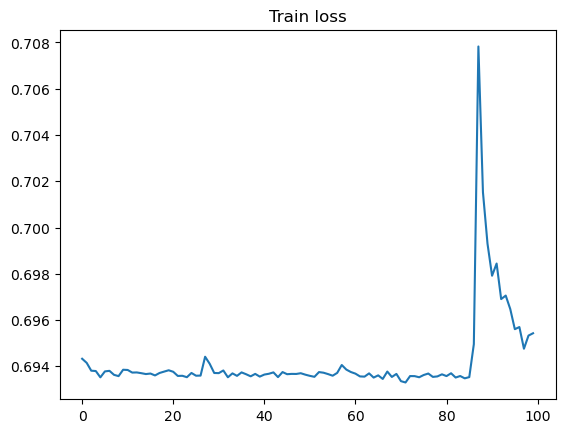

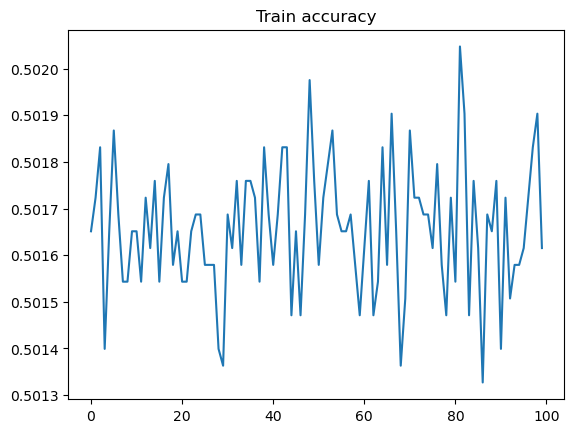

In [105]:
plt.title('Train loss')
plt.plot(range(len(train_loss)), train_loss)
plt.show()
plt.title('Train accuracy')
plt.plot(range(len(train_acc)), train_acc)
plt.show()

In [ ]:
model_name = f"GRU_{NUM_EPOCHS}_E{EMBEDDING_DIM}_H{HIDDEN_SIZE}_" +\
             f"N{NUM_LAYERS}_Bi{1 if BIDIRECTIONAL else 0}_D{DROPUT_RATE}.pt"
torch.save(model.state_dict(), model_name)